# Q3 - using trained model

we chose to use VGG16 architecture with imagenet weights. we chose imgenet becuase we found that the data of imagenet consist inages of birds, frog and some more classes we have in cifar-10. so let's start:

import relevant packages:

In [5]:
from keras.applications import VGG16
from keras.layers import *
from keras.models import *
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt


Using TensorFlow backend.


define vgg16 model with 'imagenet' weights,  and include_top=False, that means not to include first and last layers (input layer and the layers after the flatten layer will not be included).  
we also decide that the input will be 48X48, the reason is that at first we wanted to include top and only change the input shape, we found that 48X48 is the the minimum image size VGG16 supports, we train some models, but we didnt get good results and decided to change the last layer. (as we will describe later)

In [9]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(48,48,3))
vgg16.summary()

58892288/58889256 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool

change trainable to false for all the layers that were already trained by imagenet.

In [0]:
for l in vgg16.layers:
  l.trainable = False

mount to google:

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


load the train,validation data, same as we splited in Q2

In [0]:
train_X = np.load('./gdrive/My Drive/Work-1/CIFAR/data/splited_data/train_X.npy')
train_Y = np.load('./gdrive/My Drive/Work-1/CIFAR/data/splited_data/train_Y.npy')
val_X = np.load('./gdrive/My Drive/Work-1/CIFAR/data/splited_data/val_X.npy')
val_Y = np.load('./gdrive/My Drive/Work-1/CIFAR/data/splited_data/val_Y.npy')

change the size of an image to be 48X48 same as input size in our VGG16 model

In [7]:
train_X = np.array([sc.misc.imresize(x, (48,48)) for x in train_X])
val_X = np.array([sc.misc.imresize(x, (48,48)) for x in val_X])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [0]:
print('train_X shape: ' , train_X.shape)
print('val_X shape: ' , val_X.shape)

train_X shape:  (40000, 48, 48, 3)
val_X shape:  (10000, 48, 48, 3)


now we will define the last layers in VGG16 model:  
we decided not to include the last 2 conv layers, this is because as we saw in lecture, as we progress with the layers, each layer has the ability to describe more complex and wider parts of the images the model has been trained on, so we wanted to use the ability of pretrained model to recognize advance patterns in our dataset, but also not too precise.

In [11]:
x = vgg16.layers[-9].output
x = Flatten()(x)
x = BatchNormalization()(x)
pred3 = Dense(10, activation='softmax')(x)
model3 = Model(vgg16.input, pred3)
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

as we can see the model we created consist 1,864,522 parameters, but only 110,602 trainable, the rest already trained by VGG16 and we will not change it. (this give us the ability to use patterns from imagenet dataset)

compile it:

In [0]:
model3.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy']) 

using callback function as described in lecture:

In [0]:
from keras.callbacks import *

def set_callbacks(description='normal', path = '/', patience=15):
    cp = ModelCheckpoint(path + 'weights-improvement2-{epoch:02d}-{val_acc:.2f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    es = EarlyStopping(patience=patience,monitor='val_acc')   
    log = CSVLogger(path + 'train_log.csv')
    tb = TensorBoard(log_dir=path + 'logs/')
    reduce_lr_loss = ReduceLROnPlateau(monitor='acc',factor=0.1, patience=2, verbose=1, epsilon=1e-3, mpde='min')
    cb = [cp,es,log,tb,reduce_lr_loss]
    return cb

now we train our model:  
using same augmentation as described in question1 notebook.

In [0]:
from keras.preprocessing.image import ImageDataGenerator
shift=2
path='./gdrive/My Drive/Work-1/CIFAR/Q3_models/'
datagenerator = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift,fill_mode='nearest',
                             brightness_range=[0.6,1.5],
                             rotation_range=20,
                             horizontal_flip=True
                            )
datagenerator.fit(train_X)
datagenerator.fit(val_X)
BATCH_SIZE = 25
history = model3.fit_generator(datagenerator.flow(train_X,train_Y, batch_size=BATCH_SIZE), 
                                                 callbacks = set_callbacks(path),steps_per_epoch=train_X.shape[0]//BATCH_SIZE, 
                                                 validation_data=datagenerator.flow(val_X,val_Y, batch_size=BATCH_SIZE),epochs=100, validation_steps=val_X.shape[0]//BATCH_SIZE)

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/100
1600/1600 [==============================] - 79s 49ms/step - loss: 1.5371 - acc: 0.6843 - val_loss: 1.3965 - val_acc: 0.7184

Epoch 00001: val_acc improved from -inf to 0.71840, saving model to ./gdrive/My Drive/Work-1/CIFAR/try_models/weights-improvement2-01-0.72.hdf5
Epoch 2/100
1600/1600 [==============================] - 77s 48ms/step - loss: 1.4683 - acc: 0.7052 - val_loss: 1.3767 - val_acc: 0.7245

Epoch 00002: val_acc improved from 0.71840 to 0.72450, saving model to ./gdrive/My Drive/Work-1/CIFAR/try_models/weights-improvement2-02-0.72.hdf5
Epoch 3/100
1600/1600 [==============================] - 78s 49ms/step - loss: 1.4177 - acc: 0.7180 - val_loss: 1.2901 - val_acc: 0.7411

Epoch 00003: val_acc improved from 0.72450 to 0.74110, saving model to ./gdrive/My Drive/Work-1/CIFAR/try_models/weights-improvement2-03-0.74.hdf5
Epoch 4/100
1600/1600 [==============================] - 79s 49ms/step - loss: 1.3366 - acc: 0.7260 - val_loss: 1.3054 - val_acc: 0.7392

Epoch 0000

let's visualize the training by plot loss function and accuracy:

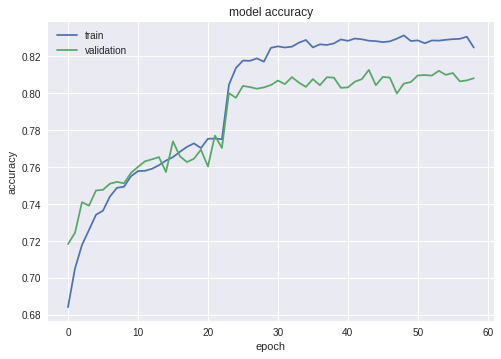

In [0]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

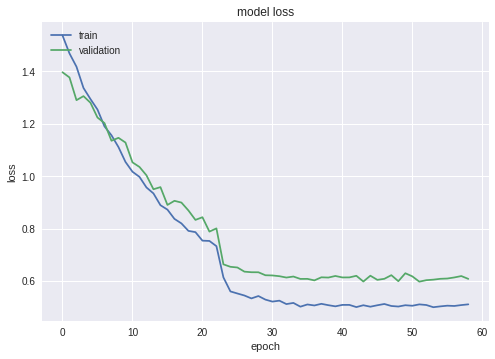

In [0]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

* as we can see the model trained almost 60 epoches, after 30 epoches the model was fitted to the train data set  (~80%) with low loss rate (~0.5).  
* we can also see that as the epoches progress and the model fit to the train data, it also fitted the validation data, and there is no point where the val_loss start to increase, from this we can conclude that the model was not get to an 'overfitting' point.  
* one more interesting thing we can notice is that in epoch 22 the acc steeply increase (and loss decrease), this is because we defined callback that decrease the learning rate. 


let's draw a confusion matrix to understand better in which image type our model is opten mistake and in which not. to do so we will predict the validation data and compare the results with val_y that is already labeled.

In [0]:
def categorial_to_label(categorial):
  num_to_labels = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',
                 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
  labeled = np.zeros((categorial.shape[0],)).astype(str)
  for i in range(categorial.shape[0]):
    p = categorial[i].argmax()
    labeled[i] = num_to_labels[p]
  return labeled

In [0]:
y_label = categorial_to_label(val_Y)
pred = model3.predict(val_X)
y_pred = categorial_to_label(pred)

Text(0.5,28.5,'True label')

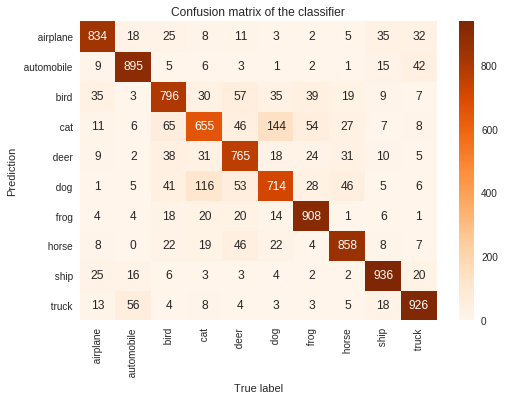

In [25]:
from string import ascii_uppercase
from pandas import DataFrame
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix

columns = [' %s' %(i) for i in ['airplane','automobile','bird','cat','deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']]
rows = [' %s' %(i) for i in ['airplane','automobile','bird','cat','deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']]

plt.title('Confusion matrix of the classifier')
confm = confusion_matrix(y_label, y_pred)
df_cm = DataFrame(confm, index=rows, columns=columns)

ax = sn.heatmap(df_cm, cmap='Oranges', annot=True,fmt='d')
plt.ylabel('Prediction')
plt.xlabel('True label')


as we can notice the situation is pretty good !!! :)  
the main diagonal is darker, which shows that in most predictions we were right.  
but there is also place to improve, as we can see the most significant issue is that the model doesn't distinguish good enough between dog and cat (on both of the sides).  about this problem we discussed and suggest solutions in Q2.  
All other errors are small in relation to the number of images and therefore tolerable.  
  
we can also see that automobile as truck and truck as automobile (~50 samples for each sides got wrong.), let's take a look about wrong predicted image of truck:

In [0]:
pred = model3.predict(val_X)
preds = categorial_to_label(pred)
indices = [i for i,v in enumerate(preds) if v=='truck' and y_label[i]=='automobile' and v!=y_label[i]]
subset_of_wrongly_predicted = [val_X[i] for i in indices ]

In [0]:
def plot_multiple_imgs(data,nrows=4,ncols=4,figsize=(18,18)):
    fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
    for i in range(nrows*ncols):
      if nrows>1:
        plot_ax = ax[i//ncols,i%ncols]
      else:
        plot_ax = ax[i]
      plot_ax.imshow(data[i])
      plot_ax.text(0.05, 0.1, str(i+1), color='white',backgroundcolor = 'black',transform=plot_ax.transAxes,weight='bold')

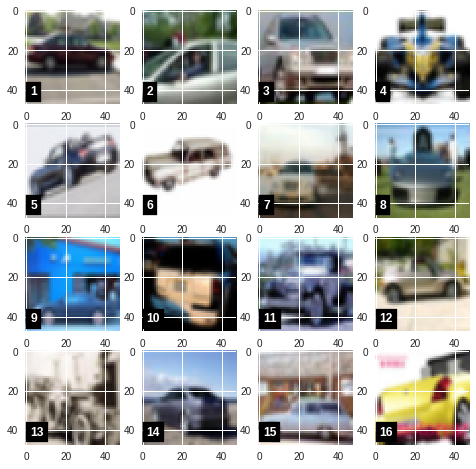

In [112]:
plot_multiple_imgs(subset_of_wrongly_predicted[:16],figsize=(8,8))

as we can notice in some of the images such as 10,3,4,11,13 , it's cars that predicted as trucks, we guess that the reason is that in these images the cars are very close to the camera and take a big size of the frame, such as trucks that are big vehicles. the problem that both of them have many patterns in common like the wheel's shape, windows and etc.  
in image 9 the car and the building with the same color , and it looks like it's one big object, very similar to truck.  
in general, these mistakes are acceptable because we know to explain them, and this is not out of context. in compare to question one we can notice that the prediction is better now. so probably we have to try to learn more patterns about the data. or another solution can be to use another model to detect special characteristics of a truck that differ it from a car.

save model weights and history:

In [0]:
np.save('./gdrive/My Drive/Work-1/CIFAR/Q3_models/history.npy', np.asarray(history3.history))

In [0]:
model3.save('./gdrive/My Drive/Work-1/CIFAR/Q3_models/final_model_3'+'.h5')

In [0]:
#in case we want to load just the weights
import os.path
path = './gdrive/My Drive/Work-1/CIFAR/Q3_models/'
filename = 'weights-improvement2-44-0.81.hdf5'
model3.load_weights(os.path.join(path, filename))

**let's predict result on kaggle test samples:**  
load test data and change size to 48X48 as the input layer

In [0]:
test_X = np.load('./gdrive/My Drive/Work-1/CIFAR/data/kaggle_test_normalized.npy')
test_X = np.array([sc.misc.imresize(x, (48,48)) for x in test_X])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [0]:
def predict_and_save(model,save_path):
    pred = model.predict(x)
    p = pred.argmax(axis=1)
    with open(save_path,'w') as f:
        f.write('id,label\n')
        for i in range(1,300001):
            f.write('{},{}\n'.format(i,num_to_labels[p[i-1]]))

In [0]:
savePath = './gdrive/My Drive/Work-1/CIFAR/Q3_models/result.csv'  
predict_and_save(model = model3,save_path = savePath)

**the result:**

In [0]:
from google.colab import files

uploaded = files.upload()

Saving kaggle_res0.829.jpg to kaggle_res0.829.jpg


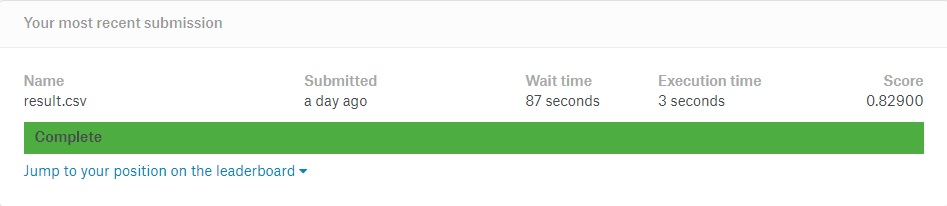

In [0]:
from IPython.display import Image, display

display(Image('kaggle_res0.829.jpg'))

** 83% !!! good results, with this model we ranked 46/231. :) **   
(and we sure we can make it even better!)

## Feature extraction

let's look again at our model:

In [0]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

we were aked to use this model as a feature extraction to classical model, as we can see all the parameters that above the last layer are already trained by imagenet dataset. so probably it will not fit comletely to our task.  
but because we asked to do that with **this model** we will try, And see if our hypothesis about the result is correct.  
  
because we are limited in time, we don't have the time to train more models in order to improve the last one, so we will explain which approach we would choose if we have time, but first let's check if our hypothesis was right:


so, if we will omit only the last layer, we will have 9216 features for each sample, this is too much and for some models it will increase the time for training, hence we decide to omit the 3 last layers and to use GlobalAveragePooling2D in order to decrese the number of features to 256:

In [0]:
x = model3.layers[-4].output
x = GlobalAveragePooling2D()(x)
model_features = Model(model3.input, x)
model_features.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

alright, now when we will predict, the model will predict 256 features per sample.  
as you can notice all the parameters were already trained for imagenet dataset. (there is no even one parameter that trained with cifar10 data)

let's continue and create our features by predict with the model:

In [0]:
def predict_feature(x_feature,x_data):
  for i in range(x_data.shape[0]):
    x_feature[i] = model_features.predict(np.expand_dims(x_data[i], axis=0))
  return x_feature

In [0]:
feature_train_x = np.zeros((train_X.shape[0],int(model_features.output.shape[1])))
feature_val_x = np.zeros((val_X.shape[0],int(model_features.output.shape[1])))
feature_train_x = predict_feature(feature_train_x,train_X)
feature_val_x = predict_feature(feature_val_x,val_X)

we will use random forest in order to classify the images, random forest demand y vector with one dimension, so for each categorial sample we will save the index of the 1 value. (that indicate the classification)

In [0]:
def categorial_to_indexed_labeled(feature,categorial):
  for i in range(feature.shape[0]):
    feature[i] = categorial[i].argmax()
  return feature

In [0]:
feature_train_y = np.zeros((train_Y.shape[0],))
feature_val_y = np.zeros((val_Y.shape[0],))
feature_train_y = categorial_to_indexed_labeled(feature_train_y,train_Y)
feature_val_y = categorial_to_indexed_labeled(feature_val_y,val_Y)

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=128, random_state=0, n_jobs=-1)#,warm_start=True,verbose=1)
clf = clf.fit(feature_train_x,feature_train_y)

In [0]:
from sklearn.metrics import accuracy_score
y_pred = clf.predict(feature_val_x)
predictions = [round(value) for value in y_pred]
accuracy_score(feature_val_y, predictions)

0.6094

as we can see we have got poor results, around 62%, we also tried other classic multi classification model, but we have got same result or even poor than that, but **we are not surprised**, and **we expect** that we will get these results.  

so **three fingers rule** when something get wrong:

***so... what we could do to make it better?***  
      with this model our only choice to get better results is to train our model again, but how to train it?  
* so the first option is to add more layers to the exist model and train the model only on these layers, after the model trained, we can use these layers for feature extraction.  
* another option is instead of adding new layers, just to train some of the existing one so the result we will get will be more fitable to our data set.  
* we can also use another pretrained model such as the model from question B that pretrained on our data set.  
  
probably we will take the last option and try it in order to break a record of ourselves, and will update on our github if it will success.  



**save the model:**

In [0]:
import pickle
# save the classifier
with open('./gdrive/My Drive/Work-1/CIFAR/Q3_models/random_forest_classifier.pkl', 'wb') as fid:
    pickle.dump(clf, fid)    
